In [ ]:
#importing libararies 
import pandas as pd
import keras
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, LSTM, Bidirectional
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
filename='/content/drive/MyDrive/Alz/preprocessed_data.pkl'

In [ ]:
#opening pickle file
data=pickle.load(open(filename,'rb'))

In [ ]:
len(data)

3243

In [ ]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
Y[794]

0

In [ ]:

X = data['Transcript'].tolist()

In [ ]:
data.head(10)

,Transcript,AD
0,um young boy getting cookie jar,1
1,and it uh bad shape uh thing,1
2,and picture mother washing dish and see it,1
3,and dish might get falled,1
4,fell fall get it,1
5,and it it picture kitchen window,1
6,and curtain uh distinct,1
7,water flow still flowing,1
8,young boy uh going cookie jar,1
9,and lit girl young girl,1


In [ ]:
X = data['Transcript'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2) 

In [ ]:
# print(len(X_train)) 
# print(len(X_test))
# print(len(Y_train))
# print(len(Y_test))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#creating tokens
def create_tokens(lines):
    tokens = Tokenizer()        
    tokens.fit_on_texts(lines)
    return tokens

In [ ]:
train_tokenizer = create_tokens(X_train)

In [ ]:
#encoding data and padding
def encode_sentences(tokens,length,lines):   
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [ ]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [ ]:

print(X_train.shape)   
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [ ]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   

847

In [ ]:
#reading glove embedding 
embeddings = dict()                                 
f = open('/content/drive/MyDrive/glove/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#CNN-LSTM model
model = Sequential()
embed = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(embed)
model.add(Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.4))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          84700     
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                11120     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 159,969
Trainable params: 75,269
Non-trainable params: 84,700
______________________________________________

In [ ]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

In [ ]:

score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 13ms/step - loss: 0.4826 - accuracy: 0.8552


0.8551617860794067

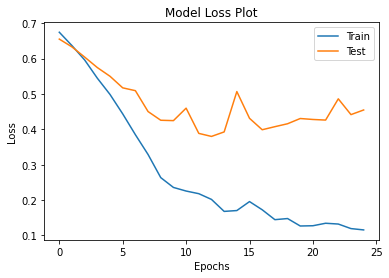

In [ ]:

import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_pretrained_history.history['loss'])
plt.plot(cnn_lstm_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
Y_pred = model.predict(X_test)